# Day 2 — Random Forests: Ensemble Learning & Stability
### Machine Learning Roadmap — Week 4
### Author — N Manish Kumar
---

Decision Trees are powerful but unstable models — small changes in data can
produce very different trees, leading to high variance and overfitting.

Random Forests solve this problem using **ensemble learning**, where many
Decision Trees are trained on different random subsets of the data and
their predictions are combined.

This technique is called **bagging (bootstrap aggregating)** and helps to:
- Reduce variance
- Improve generalization
- Produce more reliable predictions

In this notebook, we will:
- Train a single Decision Tree and a Random Forest
- Compare their training and test performance
- Observe how ensembles reduce overfitting
- Compare feature importance between models

Dataset used: **Breast Cancer Dataset (sklearn)**

---

## 1. Dataset Loading and Train/Test Split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (455, 30)
Test set shape: (114, 30)


---
## 2. Training Decision Tree and Random Forest Models

To understand the benefit of ensemble learning, we compare:

- A single Decision Tree (which may overfit)
- A Random Forest (ensemble of many trees)

Both models are trained using the same training data and evaluated on the
test set to compare their generalization performance.


In [2]:
# Decison Tree (Unconstrained Depth)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators = 200,
    random_state = 42,
    n_jobs = 1
)
rf.fit(X_train,y_train)

# Predictions
tree_train_acc = accuracy_score(y_train, tree.predict(X_train))
tree_test_acc = accuracy_score(y_test, tree.predict(X_test))

rf_train_acc = accuracy_score(y_train, rf.predict(X_train))
rf_test_acc = accuracy_score(y_test, rf.predict(X_test))

print("Decision Tree -> Train Acc:", tree_train_acc, "Test Acc:", tree_test_acc)
print("Random Forest -> Train Acc:", rf_train_acc, "Test Acc:", rf_test_acc)

Decision Tree -> Train Acc: 1.0 Test Acc: 0.9122807017543859
Random Forest -> Train Acc: 1.0 Test Acc: 0.956140350877193


### Interpretation

The Decision Tree often achieves very high or perfect training accuracy,
indicating that it memorizes the training data.

However, its test accuracy may be lower, showing overfitting.

The Random Forest typically achieves slightly lower training accuracy but
higher or more stable test accuracy, indicating better generalization due to
averaging predictions across many trees.

---
## 3. Feature Importance: Decision Tree vs Random Forest

Both Decision Trees and Random Forests provide feature importance scores based
on how much each feature reduces impurity across splits.

However:
- A single tree may rely heavily on a few splits
- Random Forest averages importance across many trees

Therefore, Random Forest importance is usually more stable and reliable.

We compare feature rankings from both models.

In [3]:
tree_importance = tree.feature_importances_
rf_importance = rf.feature_importances_

importance_df = pd.DataFrame({
    "Feature": data.feature_names,
    "Decision Tree": tree_importance,
    "Random Forest": rf_importance
}).sort_values(by="Random Forest", ascending=False)

importance_df.head(10)

,Feature,Decision Tree,Random Forest
22,worst perimeter,0.000000,0.133100
23,worst area,0.012678,0.128052
27,worst concave points,0.116083,0.108107
7,mean concave points,0.006261,0.094414
20,worst radius,0.697811,0.090639
0,mean radius,0.000000,0.058662
2,mean perimeter,0.000000,0.055242
3,mean area,0.000000,0.049938
6,mean concavity,0.000000,0.046207
26,worst concavity,0.016325,0.035357


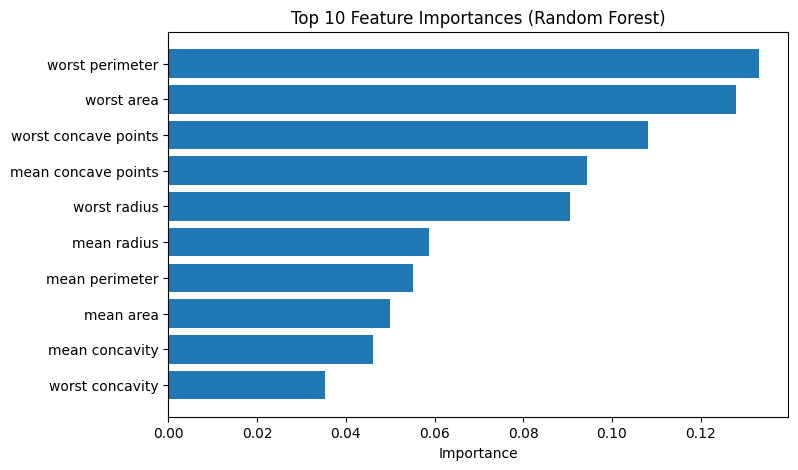

In [4]:
# Plot top 10 RF Features
top_features = importance_df.head(10)

plt.figure(figsize = (8,5))
plt.barh(top_features["Feature"],top_features["Random Forest"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

### Interpretation

Random Forest importance reflects average behavior across many trees, making it
less sensitive to noise or peculiar splits.

Features that consistently help separate classes tend to appear at the top,
which improves trust in the model’s explanations.

Single-tree importance may change significantly if the data or tree structure
changes slightly.

---
## 4. Effect of Number of Trees on Random Forest Performance

Random Forest improves stability by averaging predictions across many trees.

However, increasing the number of trees:
- Improves stability up to a point
- Increases training time
- Eventually gives diminishing returns

We train Random Forest models with different numbers of trees and compare
training and test accuracy to observe this effect.



In [5]:
n_trees_list = [10,50,100,200,400]

rf_train_acc = []
rf_test_acc = []

for n in n_trees_list:
    rf_tmp = RandomForestClassifier(
        n_estimators = n,
        random_state = 42,
        n_jobs = -1,
    )
    rf_tmp.fit(X_train,y_train)

    rf_train_acc.append(accuracy_score(y_train, rf_tmp.predict(X_train)))
    rf_test_acc.append(accuracy_score(y_test, rf_tmp.predict(X_test)))

for n, tr, te in zip(n_trees_list, rf_train_acc, rf_test_acc):
    print(f"Trees: {n}, Train Acc : {tr: .3f}, Test Acc : {te: .3f}")

Trees: 10, Train Acc :  0.996, Test Acc :  0.939
Trees: 50, Train Acc :  1.000, Test Acc :  0.956
Trees: 100, Train Acc :  1.000, Test Acc :  0.956
Trees: 200, Train Acc :  1.000, Test Acc :  0.956
Trees: 400, Train Acc :  1.000, Test Acc :  0.956


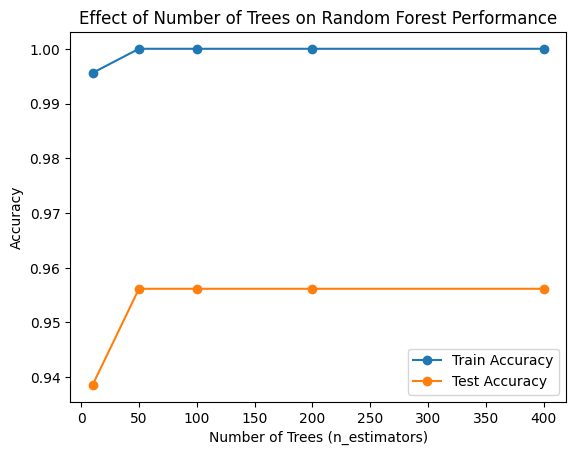

In [6]:
# Plot effect of number of trees
plt.figure()
plt.plot(n_trees_list, rf_train_acc, marker="o", label="Train Accuracy")
plt.plot(n_trees_list, rf_test_acc, marker="o", label="Test Accuracy")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Effect of Number of Trees on Random Forest Performance")
plt.legend()
plt.show()

### Interpretation

As the number of trees increases, test accuracy usually improves at first
and then stabilizes.

Training accuracy remains high, but variance reduces because predictions are
averaged across more independent trees.

After a certain point, adding more trees does not significantly improve
performance and only increases computation time.

---

## 5. Cross-Validation for Random Forest Stability

So far, we evaluated models using a single train–test split.

To confirm that Random Forest performance is reliable and not dependent on
a particular split, we perform k-fold cross-validation on the training data.

Cross-validation helps us estimate:
- Mean performance (expected accuracy)
- Variability across different data splits (stability)


In [7]:
from sklearn.model_selection import cross_val_score

rf_cv = RandomForestClassifier(
    n_estimators = 200,
    random_state = 42,
    n_jobs = -1
)

cv_scores = cross_val_score(
    rf_cv,
    X_train,
    y_train,
    cv=5,
    scoring = "accuracy",
    n_jobs = -1
)

print("CV Accuracy scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Std CV Accuracy:", cv_scores.std())

CV Accuracy scores: [0.96703297 0.98901099 0.93406593 0.94505495 0.96703297]
Mean CV Accuracy: 0.9604395604395606
Std CV Accuracy: 0.019159995356222755


### Interpretation

The mean cross-validation accuracy estimates how well the Random Forest is
expected to perform on unseen data.

A low standard deviation indicates that the model performs consistently across
different splits, which is a strong sign of stability.

This confirms that Random Forest is not only accurate but also reliable,
making it a strong candidate for real-world deployment.

---

# Notebook Summary — Week 4 Day 2

In this notebook, we studied how Random Forests improve upon single Decision
Trees by using ensemble learning and variance reduction.

### What was done
- Loaded the Breast Cancer dataset and created train/test split
- Trained a single Decision Tree and a Random Forest model
- Compared training and test accuracy to observe overfitting vs stability
- Compared feature importance from Decision Tree and Random Forest
- Studied the effect of number of trees on Random Forest performance
- Validated Random Forest stability using cross-validation

### Key Learnings
- Single Decision Trees tend to overfit due to high variance
- Random Forest reduces variance by averaging predictions across many trees
- Increasing the number of trees improves stability up to a saturation point
- Feature importance from Random Forest is more reliable than from a single tree
- Cross-validation confirms consistent generalization performance

### Final Outcome
Random Forest was shown to generalize better than a single Decision Tree and
provide stable, reliable predictions, making it a strong baseline ensemble
model for structured datasets.